This code notebook contains all three analyses from the RGID manuscript - the primary simulation example, the computational experiments, and the SUD case study example. A few important notes:
 - If you plan to load in the computational results from Github, this will require Pandas version <=2.0 (the Pandas 2.0 release broke backwards compatibility with the pickling procedure used to save the original results).
 - RGID went by the working acronym 'DIVE' during the analysis - as such, RGID computational results may be saved under the 'DIVE' acronym.

# Load packages

Load in dependencies.

In [ ]:
#Load packages and mount Drive (if connected locally)
import numpy as np
import pandas as pd #IMPORTANT: Pandas < 2.0 required if loading in computational results from benchmark experiments
import timeit
import scipy
from os import listdir
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from joblib import Parallel, delayed
import altair as alt
import warnings
import sklearn
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
import itertools
import shap
import interpret
warnings.simplefilter(action='ignore', category=FutureWarning)


Load in functions from Github scripts - rgid_functions.py and experiment_functions.py

In [ ]:
os.chdir('C:/Users/bauc9/Downloads/src/')
from rgid_functions import *
from experiment_functions import *

# Simulation Study (R^2 = 0.50)
This block generates synthetic data to assess how our 'decomposed variable importance' plots (placeholder name) can recover the original data structure. Details on the simulation's functional form can be found in the manuscript.

In [ ]:
#@title Define simulation parameters
k_e = 15 #@param {type:"integer"}
noise_sd = 6.8 #@param {type:"number"}
#Note: For variance to be equal, linear coef should be 1, squared should be 0.5, and stepwise should be 4
k = 9 + k_e #number of relevant variables (9) plus irrelevant variables (added inside data generator function)
l_c = 1 #linear coefficient
nl_c = 1 / np.sqrt(2) #quadratic coefficient (1/root(2) makes variance equal to linear term)
#s_c = 2 #stepwise coefficient (2 makes variance equal to linear term)
log_c = 2 #log coefficient (2 makes variance equal to linear term)

coef_matrix = np.array([[l_c,l_c,l_c/2,0,0,0,0,0,0], #linear coefs for 9 relevant variables
                        [0,0,0,nl_c,nl_c,nl_c/2,0,0,0], #nonlinear (exp) coefs
                        [0,0,0,0,0,0,0,0,0], #no stepwise coefs
                        [0,0,0,0,0,0,log_c,log_c,log_c/2]]) #log coefs

cor_indices = [0,3,6] #variables that will be correlated
r = 0.5 #mutual correlation for cor_indices variables
seed = 5000
interaction_tuples = [(0,4),(1,7),(2,6,8)] #vars that interact
interaction_types = ['linear','linear','stepwise']
int_coefs = [1*l_c, 1*l_c, -3*l_c] #coefficient on interactions
nonlinear_exp = 2 #nonlinear terms are quadratic

In [ ]:
#Generate simulation data (uses noise_sd defined above). Will print out R^2 for the simulated data.
from sklearn.model_selection import train_test_split
X = generate_data(k = k, cor_indices = cor_indices, n = 10000, r = r, seed = seed)
y = generate_response(data = X, linear_coefs = coef_matrix[0,:],
                      nonlinear_coefs = coef_matrix[1,:],
                      stepwise_coefs = coef_matrix[2,:],
                      log_coefs = coef_matrix[3,:],
                      log_adjust = 2.5,
                      interaction_tuples = interaction_tuples,
                      interaction_types = interaction_types,
                      int_coefs = int_coefs,
                      nonlinear_exp = nonlinear_exp,
                      noise_sd = noise_sd, seed = 1000,
                      stepwise_cutoff = 0)

#X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X = X, y = y, train_prop = (2/3), val_prop = (2/12))
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size = 0.8, random_state = 37902)

Linear, nonlinear, stepwise, and log SD are 1.4843604138776205,1.4855849615136056,0.0,2.3838601397578927
ybar SD is 3.7591017271658904
y SD is 7.80673969860864
R^2 is 0.49826580895848743


In [ ]:
#Random forest cross-validation (run to get MSE for different model configurations)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

rf1 = RandomForestRegressor(max_depth = 5, n_estimators = 100, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf2 = RandomForestRegressor(max_depth = 5, n_estimators = 500, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf3 = RandomForestRegressor(max_depth = 10, n_estimators = 100, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf4 = RandomForestRegressor(max_depth = 10, n_estimators = 500, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf5 = RandomForestRegressor(max_depth = 20, n_estimators = 100, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf6 = RandomForestRegressor(max_depth = 20, n_estimators = 500, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)

s1 = cross_validate(rf1, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s2 = cross_validate(rf2, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s3 = cross_validate(rf3, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s4 = cross_validate(rf4, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s5 = cross_validate(rf5, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s6 = cross_validate(rf6, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')

print([np.mean(s['test_score']) for s in [s1, s2, s3, s4, s5, s6]])

In [ ]:
#Train best-performing random forest.
n_trees = 500
depth = 20

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth = depth,
    n_estimators = n_trees,
    max_features = 'sqrt',
    verbose = 0,
    n_jobs = -1,
    random_state = 1000).fit(X = X_train, y = y_train)


## Run RGID for primary simulation analysis

In [ ]:
#Generate feature importance plot, and save (note: change filepath if you want to save the plot object for later)
import timeit
start = timeit.default_timer()
np.random.seed(2023)
simulation_dive = run_rgid(X = X_test, y = y_test, metric = 'rmse', model = rf,
                                 grid_size = 20,
                                 partial_out = True,
                                 pdp2_band_width = 0.1,
                                 pdp3_band_width = 0.3,
                                 pdp_ips_trim_q = 0.9,
                                 threeway_int_missing_threshold = 0.25,
                                 feature_limit = None,
                                 threeway_int_limit = 24,
                                 interaction_quantiles = (0.25, 0.75),
                                 propensity_samples = 5000,
                                 feature_imp_njobs = 1,
                                 propensity_njobs = 4,
                                 threeway_int_njobs = 4,
                                 allow_hover = True)
stop = timeit.default_timer()
runtime = stop - start
print('Time: ', runtime)

Getting ready to loop through dataset features
Calculating for each feature in order
Computed 24 PDPs
Getting propensity weights
Getting propensity weights in parallel with 4 CPUs
Computed 24 PDPs
Adjusted upper/lower cutoffs for 0 binary features
Getting 2PDQUIVER propensity weights
PDP df shape: (22080, 6)
Running through interactions
Interaction 0
Getting higher order interactions in parallel with 4 CPUs
Filtering three-way interactions for PDP matrix
Calculated three-way moderated PDPs
Three-way PDP df has 4960 rows
Generating plot


'selection_single' is deprecated.  Use 'selection_point'
'selection_multi' is deprecated.  Use 'selection_point'
'add_selection' is deprecated. Use 'add_params' instead.


Filtered PDP df has 22080 rows
based on 552 interactions with positive score
Filtered to 94 interactions
PDP df now has 4960 rows


'add_selection' is deprecated. Use 'add_params' instead.


Feature imp runtime: 119.74240139999893
PDP runtime: 0.13086810003733262
PD2ICE runtime: 4.040169350017095
PD2RIVER runtime: 0.48076720000244677
PD3ICE runtime: 27.1535266500141
PD3RIVER runtime: 0.2273778000380844
Time:  151.77893169998424


In [ ]:
#Plot
simulation_dive['plot']

alt.VConcatChart(...)

# Benchmark study (with synthetic function generation)
In this section, we use the random function generator from Friedman (2001) to get runtimes and results for RGID and all benchmarks.

## Generate data and train random forests

In [ ]:
#@title Cross-validate different random forest architectures
seed = 1000
print('Running for seed '+str(seed))

grid_res = 10

#title Generate data and create filepath for benchmark results
#BASE CASE: Use 25 features (more than Friedman and Lou) w/ 50 terms (about twice as many as features)
n_t = 50 #number of terms - Friedman 2001 uses n_t = 20
_lambda = 2 #mean of the exp distribution that decides interaction sizes. Friedman used 2, Lou FAST paper used 1
m = 25 #Friedman used 10 (w/ 20 terms). Lou (FAST) used 10 (w/ 25 terms) and 100 (w/ 1000 terms)
n = 10000 #consistent with Friedman and about the geometric mean of Lou (FAST)
eigen_a_c, eigen_b_c = 0.1, 2 #eigenvalues for generating variance/covariance matrix.
eigen_a_g, eigen_b_g = 0.1, 2 #eigenvalues for multivariate normal function g
sn_ratio = 1 #consistent with Friedman

X, y, z_l, a_l = generate_random_data(n_t = n_t, _lambda = _lambda, m = m, n = n,
                                eigen_list = [eigen_a_c, eigen_b_c, eigen_a_g, eigen_b_g],
                                sn_ratio = sn_ratio, seed = seed)

#Split data
from sklearn.model_selection import train_test_split
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size = 0.8, random_state = 37902)

#Train a few random forests and choose the best ones
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

rf1 = RandomForestRegressor(max_depth = 5, n_estimators = 100, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf2 = RandomForestRegressor(max_depth = 5, n_estimators = 500, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf3 = RandomForestRegressor(max_depth = 10, n_estimators = 100, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf4 = RandomForestRegressor(max_depth = 10, n_estimators = 500, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf5 = RandomForestRegressor(max_depth = 20, n_estimators = 100, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)
rf6 = RandomForestRegressor(max_depth = 20, n_estimators = 500, max_features = 'sqrt', verbose = 0, n_jobs = -1, random_state = 2025)

s1 = cross_validate(rf1, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s2 = cross_validate(rf2, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s3 = cross_validate(rf3, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s4 = cross_validate(rf4, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s5 = cross_validate(rf5, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')
s6 = cross_validate(rf6, X = X_train, y = y_train, scoring = 'neg_root_mean_squared_error')

print([np.mean(s['test_score']) for s in [s1, s2, s3, s4, s5, s6]])


In [ ]:
#Quantify the proportion of terms with pairwise/three-way interactions
z_list = []
for seed in [37902, 37912, 37922, 37932, 37942]:
  print('Running for seed '+str(seed))

  #Define empty benchmark object and grid_size
  benchmark_results = {}

  grid_res = 10

  #title Generate data and create filepath for benchmark results
  #BASE CASE: Use 25 features (more than Friedman and Lou) w/ 50 terms (about twice as many as features)
  n_t = 50 #number of terms - Friedman 2001 uses n_t = 20
  _lambda = 2 #mean of the exp distribution that decides interaction sizes. Friedman used 2, Lou FAST paper used 1
  m = 25 #Friedman used 10 (w/ 20 terms). Lou (FAST) used 10 (w/ 25 terms) and 100 (w/ 1000 terms)
  n = 10000 #consistent with Friedman and about the geometric mean of Lou (FAST)
  eigen_a_c, eigen_b_c = 0.1, 2 #eigenvalues for generating variance/covariance matrix.
  eigen_a_g, eigen_b_g = 0.1, 2 #eigenvalues for multivariate normal function g
  sn_ratio = 1 #consistent with Friedman

  X, y, z_l, a_l = generate_random_data(n_t = n_t, _lambda = _lambda, m = m, n = n,
                                  eigen_list = [eigen_a_c, eigen_b_c, eigen_a_g, eigen_b_g],
                                  sn_ratio = sn_ratio, seed = seed)
  z_list.append(z_l)

term_lengths = np.concatenate([np.array([len(z) for z in z_l]) for z_l in z_list])
print([np.mean(term_lengths==l) for l in [1,2,3]])
print(np.mean(term_lengths))

Running for seed 37902
Average correlation is 0.10802567887959086
Ybar median abs. deviation is 0.7986310330169138
Error median abs. deviation is 0.795416331975112
Running for seed 37912
Average correlation is 0.13119752314150365
Ybar median abs. deviation is 0.6579822576265763
Error median abs. deviation is 0.6606939154705642
Running for seed 37922
Average correlation is 0.15794462324110317
Ybar median abs. deviation is 0.9337664127022234
Error median abs. deviation is 0.9276317253527839
Running for seed 37932
Average correlation is 0.12538350069470022
Ybar median abs. deviation is 0.6269821309073961
Error median abs. deviation is 0.634485639820281
Running for seed 37942
Average correlation is 0.12368913597143534
Ybar median abs. deviation is 0.6264720202398563
Error median abs. deviation is 0.6251865057130426
[0.224, 0.308, 0.2]
2.852


## Run computational results
This is the 'master code block' that runs through RGID and all benchmark methods for a given synthetic dataset.

In [ ]:
#Run benchmark analysis for multiple seeds
os.chdir('C:/Users/bauc9/Downloads/data/')
for seed in [37902, 37912, 37922, 37932, 37942]:
  print('Running for seed '+str(seed))

  #Define empty benchmark object and grid_size
  benchmark_results = {}

  grid_res = 10

  #title Generate data and create filepath for benchmark results
  #BASE CASE: Use 25 features (more than Friedman and Lou) w/ 50 terms (about twice as many as features)
  n_t = 50 #number of terms - Friedman 2001 uses n_t = 20
  _lambda = 2 #mean of the exp distribution that decides interaction sizes. Friedman used 2, Lou FAST paper used 1
  m = 25 #Friedman used 10 (w/ 20 terms). Lou (FAST) used 10 (w/ 25 terms) and 100 (w/ 1000 terms)
  n = 10000 #consistent with Friedman and about the geometric mean of Lou (FAST)
  eigen_a_c, eigen_b_c = 0.1, 2 #eigenvalues for generating variance/covariance matrix.
  eigen_a_g, eigen_b_g = 0.1, 2 #eigenvalues for multivariate normal function g
  sn_ratio = 1 #consistent with Friedman

  X, y, z_l, a_l = generate_random_data(n_t = n_t, _lambda = _lambda, m = m, n = n,
                                  eigen_list = [eigen_a_c, eigen_b_c, eigen_a_g, eigen_b_g],
                                  sn_ratio = sn_ratio, seed = seed)

  #Split data
  from sklearn.model_selection import train_test_split
  X_test, X_train, y_test, y_train = train_test_split(X, y, test_size = 0.8, random_state = 37902)

  #Train a few random forests and choose the best ones
  n_trees = 500 #based on cross-validation with seed = 1000
  depth = 20 #based on cross-validation with seed = 1000

  #Create filepath
  benchmark_filepath = 'benchmark_results_nt'+str(n_t)+'_l'+str(_lambda)+'_m'+str(m)+'_n'+str(n)+'_sn' \
    + str(sn_ratio)+'_grid'+str(grid_res)+'_trees'+str(n_trees)+'_depth'+str(depth)+'_seed'+str(seed)+'.joblib'
  print(benchmark_filepath)

  #Save data
  benchmark_results['Data'] = {'X': X, 'y': y, 'z_l': z_l, 'a_l': a_l}

  #title Train final random forest
  from sklearn.ensemble import RandomForestRegressor
  rf = RandomForestRegressor(max_depth = depth,
      n_estimators = n_trees,
      max_features = 'sqrt',
      verbose = 0,
      n_jobs = -1,
      random_state = 37902).fit(X = X_train, y = y_train)

  #title DIVE dashboard
  import timeit
  start = timeit.default_timer()
  np.random.seed(2023)
  simulation_dive = run_rgid(X = X_test, y = y_test, metric = 'rmse', model = rf,
                                  grid_size = grid_res,
                                  partial_out = True,
                                  adjust_pairwise_interactions = False,
                                  adjust_threeway_interactions = False,
                                  pdp2_band_width = 0.1,
                                  pdp3_band_width = 0.3,
                                  pdp_ips_trim_q = 0.9,
                                  #feature_limit = 20, #ONLY USE LIMIT IF SCREENSHOTTING - otherwise, run all for runtime purposes
                                  threeway_int_limit = 25,
                                  interaction_quantiles = (0.25, 0.75),
                                  feature_imp_njobs = 1,
                                  propensity_njobs = 4,
                                  threeway_int_njobs = 4)

  stop = timeit.default_timer()
  runtime = stop - start
  print('Time: ', runtime)

  #Save to dive_results dict
  benchmark_results['Feature Imp - DIVE'] = {'Results': simulation_dive['graph_df'], 'Runtime': simulation_dive['runtime_dict']['Feature imp runtime']}
  benchmark_results['Univariate Interactions - DIVE'] = {'Results': simulation_dive['graph_df'], 'Runtime': 0}
  benchmark_results['One-way PDPs - DIVE'] = {'Results': simulation_dive['pdp_df_oneway'], 'Runtime': simulation_dive['runtime_dict']['PDP runtime']}
  benchmark_results['Pairwise Interactions - DIVE'] = {'Results': simulation_dive['int_df'], 'Runtime': simulation_dive['runtime_dict']['PD2ICE runtime']}
  benchmark_results['Two-way PDPs - DIVE'] = {'Results': simulation_dive['pdp_df_twoway'], 'Runtime': simulation_dive['runtime_dict']['PD2RIVER runtime']}
  benchmark_results['Three-way Interactions - DIVE'] = {'Results':
              [simulation_dive['threeway_int_tuples'], simulation_dive['threeway_int_score_matrix']],
              'Runtime': simulation_dive['runtime_dict']['PD3ICE runtime']}
  benchmark_results['Three-way PDPs - DIVE'] = {'Results':
              [simulation_dive['higher_order_df'][['Feature Num','Interaction']], simulation_dive['pdp_df_threeway']],
              'Runtime': simulation_dive['runtime_dict']['PD3RIVER runtime']}

  #Save benchmark results
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

  #PLOT 1: FEATURE IMPORTANCE (n_jobs = -1)
  print("FEATURE IMPORTANCE (PLOT 1)")
    #Scikit-learn permutation importance
  print('Scikit-learn permutation importance')
  from sklearn.inspection import permutation_importance
  n_permute = 5 #the default
  start = timeit.default_timer()
  result = permutation_importance(rf, X_test, y_test, n_repeats = n_permute,
                                      scoring = 'neg_root_mean_squared_error', random_state=2023,n_jobs = -1)
  importance_scores_SKLEARN = result.importances_mean
  stop = timeit.default_timer()
  scikit_permutation_runtime = stop - start
      #Append to benchmark results dictionary
  benchmark_results['Feature Imp - sklearn'] = {'Results': np.array(importance_scores_SKLEARN), 'Runtime': scikit_permutation_runtime}
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

    #SHAP (no parallel option)
  print('SHAP feature importance')
  import shap
  start = timeit.default_timer()
  explainer = shap.Explainer(rf, X_test, seed = 32301)
  shap_values = explainer(X_test)
  importance_scores_SHAP = np.abs(shap_values.values).mean(axis = 0)
  stop = timeit.default_timer()
  shap_runtime = stop - start
      #Append to benchmark results dictionary
  benchmark_results['Feature Imp - SHAP'] = {'Results': np.array(importance_scores_SHAP), 'Runtime': shap_runtime}
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

  #PLOT 1: UNIVARIATE H^2 STATISTICS
  print('UNIVARIATE H^2 STATISTICS (Plot 1)')
    #Basic H^2 statistic (from R package 'pre')
  start = timeit.default_timer()
  interaction_scores_h2 = []

  for f in range(X.shape[1]):
    print(f)
    interaction_scores_h2.append(hsquared(rf, f = f, X = X_test, grid_size = grid_res, predict_proba = False))

  stop = timeit.default_timer()
  h2_runtime = stop - start
      #Append to benchmark results dictionary
  benchmark_results['Univariate Interactions - H2'] = {'Results': np.array(interaction_scores_h2), 'Runtime': h2_runtime}
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

  #PLOT 2: PDPs (method = auto)
  print('Univariate PDPs (Plot 2)')
    #Scikit learn univariate PDPs
  from sklearn.inspection import PartialDependenceDisplay, partial_dependence
  start = timeit.default_timer()
  sk_dfs = []

  for v in np.arange(X_test.shape[1]): #zip with index_tuples if wanting to plot
    print(v)
    pdp = partial_dependence(rf, X_test, [v], kind = 'average', grid_resolution = grid_res, method = 'auto')
    sk_dfs.append(pd.DataFrame({'Feature_Num': v, 'X': pdp['values'][0], 'Y': pdp['average'][0]}))
  stop = timeit.default_timer()
  pdp_runtime = stop - start
      #Append to benchmark results dictionary
  benchmark_results['One-way PDPs - sklearn'] = {'Results': sk_dfs, 'Runtime': pdp_runtime}
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

  #PLOT 3: PAIRWISE INTERACTIONS (method = auto, manually parallel)
  print('Pairwise Interaction Scores (Plot 3)')
    #Pairwise H^2 statistics
  start = timeit.default_timer()
  pairwise_scores_h2 = []
  int_tuples = []
  delayed_funcs = []

  counter=-1
  for f1 in range(X.shape[1]):
    for f2 in range(f1):
      print(f1, f2)
      counter += 1
      int_tuples.append((f1, f2))
      twoway_pdp = partial_dependence(rf, X_test, [f1,f2], kind = 'average',
                                      grid_resolution = grid_res, method = 'auto')
      #pdp_1, pdp_2 = sk_dfs[f1]['Y'].to_numpy(), sk_dfs[f2]['Y'].to_numpy() #using marginals from two-way instead
      twoway_pdp_s = twoway_pdp['average'][0] - twoway_pdp['average'][0].mean()
      pdp_1, pdp_2 = twoway_pdp_s.mean(axis = 1), twoway_pdp_s.mean(axis = 0)
      pdp_1_s = (pdp_1 - pdp_1.mean()).reshape(-1,1)
      pdp_2_s = (pdp_2 - pdp_2.mean()).reshape(1,-1)
      pairwise_scores_h2.append(
        ((twoway_pdp_s - pdp_1_s - pdp_2_s)**2).sum() / (twoway_pdp_s**2).sum()
      )
  pairwise_h2_df = pd.DataFrame({'Int Tuple': int_tuples, 'H2 Score': np.array(pairwise_scores_h2)})
  stop = timeit.default_timer()
  pairwise_h2_runtime = stop - start
      #Append to benchmark results dictionary
  benchmark_results['Pairwise Interactions - H2'] = {'Results': pairwise_h2_df, 'Runtime': pairwise_h2_runtime}
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

    #FAST (implemented through EBM ; n_jobs = -1)
  print('FAST algorithm')
  from interpret.glassbox import ExplainableBoostingRegressor
  start = timeit.default_timer()
  ebm = ExplainableBoostingRegressor(interactions = n_t, n_jobs = -1) #50 INTERACTIONS
  ebm.fit(pd.DataFrame(X_train, columns = ['X'+str(i) for i in range(X_train.shape[1])]), y_train)
  stop = timeit.default_timer()
  FAST_runtime = stop - start
  importances, names = ebm.term_importances(), ebm.term_names_
  int_tuples, term_importance_list = [], []
  for (term_name, importance) in zip(names, importances):
    term_name = term_name.replace('feature_','')
    if '&' in term_name:
      v1, v2 = term_name.replace(' ','').replace('X','').split('&')
      int_tuples.append((int(v1), int(v2)))
      term_importance_list.append(importance)

  pairwise_FAST_df = pd.DataFrame({'Feature': int_tuples, 'Imp': term_importance_list})
      #Append to benchmark results dictionary
  benchmark_results['Pairwise Interactions - FAST'] = {'Results': pairwise_FAST_df, 'Runtime': FAST_runtime}
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

  #Plot 4: PAIRWISE PDPs (method = brute)
  print('Pairwise PDPs')
    #Scikit learn moderated PDPs
  #low_mask = simulation_dive['x_residuals'] < np.quantile(simulation_dive['x_residuals'], 0.25, axis = 0).reshape(1,-1)
  #high_mask = simulation_dive['x_residuals'] > np.quantile(simulation_dive['x_residuals'], 0.75, axis = 0).reshape(1,-1)
  low_mask = X_test < np.quantile(X_test, 0.25, axis = 0).reshape(1,-1)
  high_mask = X_test > np.quantile(X_test, 0.75, axis = 0).reshape(1,-1)
  high_avg_values = np.array([X_test[:,k][high_mask[:,k]].mean() for k in range(X_test.shape[1])])
  low_avg_values = np.array([X_test[:,k][low_mask[:,k]].mean() for k in range(X_test.shape[1])])
  start = timeit.default_timer()

  pdp_sk_df_low_list, pdp_sk_df_high_list = [], []
  counter = -1
  for v1 in np.arange(X_test.shape[1]):
    for v2 in range(v1):
      print(v1,v2)
      counter += 1
      X_impute_low, X_impute_high = np.array(X_test), np.array(X_test)
      X_impute_low[:,v2] = low_avg_values[v2]
      X_impute_high[:,v2] = high_avg_values[v2]

      pdp_low = partial_dependence(rf, X_impute_low, [v1], kind = 'average',
                                   grid_resolution = grid_res, method = 'brute')
      pdp_high = partial_dependence(rf, X_impute_high, [v1], kind = 'average',
                                    grid_resolution = grid_res, method = 'brute')

      if np.all(pdp_low['average'] == pdp_high['average']):
        print("PDPs are identical!")

      pdp_sk_df_low, pdp_sk_df_high = [pd.DataFrame({'Feature': v1, 'Feature 2': v2,
        'X': p['values'][0],'Feature 2 Level': label,'Y': p['average'][0]}
        ) for p, label in zip([pdp_low,pdp_high],['Low','High'])]
      pdp_sk_df_low_list.append(pdp_sk_df_low)
      pdp_sk_df_high_list.append(pdp_sk_df_high)
  pdp_df_twoway_SK = pd.concat(pdp_sk_df_low_list+pdp_sk_df_high_list, axis = 0)
  stop = timeit.default_timer()
  mod_pdp_runtime = stop - start
      #Append to benchmark results dictionary
  benchmark_results['Two-way PDPs - sklearn'] = {'Results': pdp_df_twoway_SK, 'Runtime': mod_pdp_runtime}
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

  #Plot 5: THREE-WAY INTERACTIONS (method = 'auto')
    #Three-way H^2 statistics
  print('Three-way interactions')
  int_tuples_to_test = simulation_dive['threeway_int_tuples']
  threeway_int_score_matrix_H2 = np.zeros((len(int_tuples_to_test), X_test.shape[1]))
  start = timeit.default_timer()

  row_counter = -1
  result_counter = -1
  for _int in int_tuples_to_test:
    row_counter += 1
    f2, f3 = _int[0], _int[1]
    for f1 in range(X_test.shape[1]):
      if f1 not in _int:
        pdp = partial_dependence(rf, X_test, [f1,f2,f3], kind = 'average',
                                         grid_resolution = grid_res, method = 'auto')
        pdp_threeway = pdp['average'][0]
        pdp_threeway_s = pdp_threeway - pdp_threeway.mean()

        pdp_twoway_1 = np.expand_dims(np.mean(pdp_threeway_s, axis = 2), 2)
        pdp_twoway_2 = np.expand_dims(np.mean(pdp_threeway_s, axis = 0), 0)
        pdp_twoway_3 = np.expand_dims(np.mean(pdp_threeway_s, axis = 1), 1)

        pdp_1 = np.expand_dims(np.mean(pdp_threeway_s, axis = (1,2)), axis = (1,2))
        pdp_2 = np.expand_dims(np.mean(pdp_threeway_s, axis = (0,2)), axis = (0,2))
        pdp_3 = np.expand_dims(np.mean(pdp_threeway_s, axis = (0,1)), axis = (0,1))

        pdp_threeway_s = pdp_threeway - pdp_threeway.mean()
        pdp_twoway_1_s = pdp_twoway_1 - pdp_twoway_1.mean()
        pdp_twoway_2_s = pdp_twoway_2 - pdp_twoway_2.mean()
        pdp_twoway_3_s = pdp_twoway_3 - pdp_twoway_3.mean()
        pdp_1_s = pdp_1 - pdp_1.mean()
        pdp_2_s = pdp_2 - pdp_2.mean()
        pdp_3_s = pdp_3 - pdp_3.mean()

        h2_threeway = np.sum(
            (
                pdp_threeway_s - pdp_twoway_1_s - pdp_twoway_2_s  - pdp_twoway_3_s \
                + pdp_1_s  + pdp_2_s  + pdp_3_s
            )**2) / np.sum((pdp_threeway_s)**2)

        threeway_int_score_matrix_H2[row_counter, f1] = h2_threeway

  stop = timeit.default_timer()
  threeway_h2_runtime = stop - start
      #Append to benchmark results dictionary
  benchmark_results['Three-way Interactions - H2'] = {'Results': threeway_int_score_matrix_H2, 'Runtime': threeway_h2_runtime}
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

  #Plot 6: THREE-WAY PDPs (method = 'brute')
  print('Three-way PDPs')
    #Scikit learn moderated PDPs
  pdp_sk_df_low_low_list, pdp_sk_df_low_high_list, pdp_sk_df_high_low_list, pdp_sk_df_high_high_list = [], [], [], []

  #int_tuples_to_test = simulation_dive['threeway_int_tuples']
  pdp_df_threeway = simulation_dive['pdp_df_threeway']
  start = timeit.default_timer()

  delayed_funcs_low_low = []
  delayed_funcs_low_high = []
  delayed_funcs_high_low = []
  delayed_funcs_high_high = []

  for f1 in range(X_test.shape[1]):
    print(f1)
    pdp_df_threeway_filt = pdp_df_threeway[pdp_df_threeway['Feature']=='X'+str(f1)]
    interactions = pdp_df_threeway_filt[['Interaction V1','Interaction V2']].drop_duplicates()
    print('Computing moderated PDPs for '+str(interactions.shape[0])+' interactions')
    if interactions.shape[0] > 0:
      for row in range(interactions.shape[0]):
        f2, f3 = interactions['Interaction V1'].iloc[row], interactions['Interaction V2'].iloc[row]
        print(f1, f2, f3)
        X_impute_low_low, X_impute_low_high, X_impute_high_low, X_impute_high_high = np.array(X_test), np.array(X_test), np.array(X_test), np.array(X_test)
        X_impute_low_low[:,f2] = low_avg_values[f2] ; X_impute_low_low[:,f3] = low_avg_values[f3]
        X_impute_low_high[:,f2] = low_avg_values[f2] ; X_impute_low_high[:,f3] = high_avg_values[f3]
        X_impute_high_low[:,f2] = high_avg_values[f2] ; X_impute_high_low[:,f3] = low_avg_values[f3]
        X_impute_high_high[:,f2] = high_avg_values[f2] ; X_impute_high_high[:,f3] = high_avg_values[f3]

        pdp_low_low = partial_dependence(rf, X_impute_low_low, [f1], kind = 'average', grid_resolution = grid_res, method = 'brute')
        pdp_low_high = partial_dependence(rf, X_impute_low_high, [f1], kind = 'average', grid_resolution = grid_res, method = 'brute')
        pdp_high_low = partial_dependence(rf, X_impute_high_low, [f1], kind = 'average', grid_resolution = grid_res, method = 'brute')
        pdp_high_high = partial_dependence(rf, X_impute_high_high, [f1], kind = 'average', grid_resolution = grid_res, method = 'brute')

        pdp_sk_df_low_low, pdp_sk_df_low_high, pdp_sk_df_high_low, pdp_sk_df_high_high = [
          pd.DataFrame({'Feature': f1, 'Feature 2': f2, 'Feature 3': f3,
          'X': p['values'][0],'Feature 2 Level': label2,'Feature 3 Level': label3, 'Y': p['average'][0]}
          ) for p, label2, label3 in zip([pdp_low_low, pdp_low_high, pdp_high_low, pdp_high_high],
                                        ['Low','Low','High','High'], ['Low','High','Low','High'])
          ]
        pdp_sk_df_low_low_list.append(pdp_sk_df_low_low)
        pdp_sk_df_low_high_list.append(pdp_sk_df_low_high)
        pdp_sk_df_high_low_list.append(pdp_sk_df_high_low)
        pdp_sk_df_high_high_list.append(pdp_sk_df_high_high)

  pdp_df_threeway_SK = pd.concat(pdp_sk_df_low_low_list + pdp_sk_df_low_high_list + pdp_sk_df_high_low_list + pdp_sk_df_high_high_list, axis = 0)
  stop = timeit.default_timer()
  threeway_mod_pdp_runtime = stop - start
      #Append to benchmark results dictionary
  benchmark_results['Three-way PDPs - sklearn'] = {'Results': pdp_df_threeway_SK, 'Runtime': threeway_mod_pdp_runtime}
  joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)


This is the supplementary code block that runs the fastest benchmarks for different numbers of features.

In [ ]:
#@title DONT RUN UNLESS REDOING - Best benchmark methods by number of features
for seed in [37902, 37912, 37922, 37932, 37942]:
  for m in [50, 10, 5]:
    print('Running for seed '+str(seed))
    print(f'Running with {m} features')

    #Define empty benchmark object and grid_size
    benchmark_results = {}

    grid_res = 10

    #title Generate data and create filepath for benchmark results
    #BASE CASE: Use 25 features (more than Friedman and Lou) w/ 50 terms (about twice as many as features)
    n_t = 50 #number of terms - Friedman 2001 uses n_t = 20
    _lambda = 2 #mean of the exp distribution that decides interaction sizes. Friedman used 2, Lou FAST paper used 1
    n = 10000 #consistent with Friedman and about the geometric mean of Lou (FAST)
    eigen_a_c, eigen_b_c = 0.1, 2 #eigenvalues for generating variance/covariance matrix.
    eigen_a_g, eigen_b_g = 0.1, 2 #eigenvalues for multivariate normal function g
    sn_ratio = 1 #consistent with Friedman

    if (seed == 37942) & (m <= 10): #37942 generates multicollinear variables
        X, y, z_l, a_l = generate_random_data(n_t = n_t, _lambda = _lambda, m = m, n = n,
                                    eigen_list = [eigen_a_c, eigen_b_c, eigen_a_g, eigen_b_g],
                                    sn_ratio = sn_ratio, seed = seed+5)
    else:
        X, y, z_l, a_l = generate_random_data(n_t = n_t, _lambda = _lambda, m = m, n = n,
                                    eigen_list = [eigen_a_c, eigen_b_c, eigen_a_g, eigen_b_g],
                                    sn_ratio = sn_ratio, seed = seed)


    #Split data
    from sklearn.model_selection import train_test_split
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size = 0.8, random_state = 37902)

    #Train a few random forests and choose the best ones
    n_trees = 500
    depth = 20

    #Create filepath
    benchmark_filepath = 'benchmark_results_nt'+str(n_t)+'_l'+str(_lambda)+'_m'+str(m)+'_n'+str(n)+'_sn' \
      + str(sn_ratio)+'_trees'+str(n_trees)+'_depth'+str(depth)+'_seed'+str(seed)+'.joblib'
    print(benchmark_filepath)


    #Save data
    benchmark_results['Data'] = {'X': X, 'y': y, 'z_l': z_l, 'a_l': a_l}

    #title Train final random forest
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(max_depth = depth,
        n_estimators = n_trees,
        max_features = 'sqrt',
        verbose = 0,
        n_jobs = -1,
        random_state = 37902).fit(X = X_train, y = y_train)

    #title DIVE dashboard
    import timeit
    start = timeit.default_timer()
    np.random.seed(2023)
    simulation_dive = run_rgid(X = X_test, y = y_test, metric = 'rmse', model = rf,
                                  grid_size = grid_res,
                                  partial_out = True,
                                  adjust_pairwise_interactions = False,
                                  adjust_threeway_interactions = False,
                                  pdp2_band_width = 0.1,
                                  pdp3_band_width = 0.3,
                                  pdp_ips_trim_q = 0.9,
                                  #feature_limit = 20, #ONLY USE LIMIT IF SCREENSHOTTING - otherwise, run all for runtime purposes
                                  threeway_int_limit = 25,
                                  interaction_quantiles = (0.25, 0.75),
                                  feature_imp_njobs = 1,
                                  propensity_njobs = 4,
                                  threeway_int_njobs = 4)
    stop = timeit.default_timer()
    runtime = stop - start
    print('Time: ', runtime)

    #Save to dive_results dict
    benchmark_results['Feature Imp - DIVE'] = {'Results': simulation_dive['graph_df'], 'Runtime': simulation_dive['runtime_dict']['Feature imp runtime']}
    benchmark_results['Univariate Interactions - DIVE'] = {'Results': simulation_dive['graph_df'], 'Runtime': 0}
    benchmark_results['One-way PDPs - DIVE'] = {'Results': simulation_dive['pdp_df_oneway'], 'Runtime': simulation_dive['runtime_dict']['PDP runtime']}
    benchmark_results['Pairwise Interactions - DIVE'] = {'Results': simulation_dive['int_df'], 'Runtime': simulation_dive['runtime_dict']['PD2ICE runtime']}
    benchmark_results['Two-way PDPs - DIVE'] = {'Results': simulation_dive['pdp_df_twoway'], 'Runtime': simulation_dive['runtime_dict']['PD2RIVER runtime']}
    benchmark_results['Three-way Interactions - DIVE'] = {'Results':
                [simulation_dive['threeway_int_tuples'], simulation_dive['threeway_int_score_matrix']],
                'Runtime': simulation_dive['runtime_dict']['PD3ICE runtime']}
    benchmark_results['Three-way PDPs - DIVE'] = {'Results':
                [simulation_dive['higher_order_df'][['Feature Num','Interaction']], simulation_dive['pdp_df_threeway']],
                'Runtime': simulation_dive['runtime_dict']['PD3RIVER runtime']}

    #Save benchmark results
    joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

    #title Run ALL benchmark methods for randomly generated function

    #PLOT 1: FEATURE IMPORTANCE
    print("FEATURE IMPORTANCE (PLOT 1)")
      #Scikit-learn permutation importance
    print('Scikit-learn permutation importance')
    from sklearn.inspection import permutation_importance
    n_permute = 5 #the default
    start = timeit.default_timer()
    result = permutation_importance(rf, X_test, y_test, n_repeats = n_permute,
                                        scoring = 'neg_root_mean_squared_error', random_state=2023,n_jobs = -1)
    importance_scores_SKLEARN = result.importances_mean
    stop = timeit.default_timer()
    scikit_permutation_runtime = stop - start

        #Append to benchmark results dictionary
    benchmark_results['Feature Imp - sklearn'] = {'Results': np.array(importance_scores_SKLEARN), 'Runtime': scikit_permutation_runtime}
    joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

    #PLOT 1: UNIVARIATE H^2 STATISTICS
    print('UNIVARIATE H^2 STATISTICS (Plot 1)')
      #Basic H^2 statistic (from R package 'pre')
    start = timeit.default_timer()
    interaction_scores_h2 = []
    for f in range(X.shape[1]):
      print(f)
      interaction_scores_h2.append(hsquared(rf, f = f, X = X_test,
                                          grid_size = grid_res, predict_proba = False))
    stop = timeit.default_timer()
    h2_runtime = stop - start
        #Append to benchmark results dictionary
    benchmark_results['Univariate Interactions - H2'] = {'Results': np.array(interaction_scores_h2), 'Runtime': h2_runtime}
    joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

    #PLOT 2: PDPs
    print('Univariate PDPs (Plot 2)')
      #Scikit learn univariate PDPs
    from sklearn.inspection import PartialDependenceDisplay, partial_dependence
    start = timeit.default_timer()
    sk_dfs = []
    for v in np.arange(X_test.shape[1]): #zip with index_tuples if wanting to plot
      print(v)
      pdp = partial_dependence(rf, X_test, [v], kind = 'average',grid_resolution = grid_res, method = 'auto')
      sk_dfs.append(pd.DataFrame({'Feature_Num': v, 'X': pdp['values'][0], 'Y': pdp['average'][0]}))
    stop = timeit.default_timer()
    pdp_runtime = stop - start
        #Append to benchmark results dictionary
    benchmark_results['One-way PDPs - sklearn'] = {'Results': sk_dfs, 'Runtime': pdp_runtime}
    joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

    #PLOT 3: PAIRWISE INTERACTIONS
    print('Pairwise Interaction Scores (Plot 3)')
      #FAST (implemented through EBM)
    from interpret.glassbox import ExplainableBoostingRegressor
    start = timeit.default_timer()
    ebm = ExplainableBoostingRegressor(interactions = np.min([n_t, X.shape[1]**2]), n_jobs = -1) #50 INTERACTIONS
    ebm.fit(pd.DataFrame(X_train, columns = ['X'+str(i) for i in range(X_train.shape[1])]), y_train)
    stop = timeit.default_timer()
    FAST_runtime = stop - start
    importances, names = ebm.term_importances(), ebm.term_names_
    int_tuples, term_importance_list = [], []
    for (term_name, importance) in zip(names, importances):
      term_name = term_name.replace('feature_','')
      if '&' in term_name:
        v1, v2 = term_name.replace(' ','').replace('X','').split('&')
        int_tuples.append((int(v1), int(v2)))
        term_importance_list.append(importance)

    pairwise_FAST_df = pd.DataFrame({'Feature': int_tuples, 'Imp': term_importance_list})
        #Append to benchmark results dictionary
    benchmark_results['Pairwise Interactions - FAST'] = {'Results': pairwise_FAST_df, 'Runtime': FAST_runtime}
    joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)

    #Plot 4: PAIRWISE PDPs (method = brute)
    print('Pairwise PDPs')
      #Scikit learn moderated PDPs
    #low_mask = simulation_dive['x_residuals'] < np.quantile(simulation_dive['x_residuals'], 0.25, axis = 0).reshape(1,-1)
    #high_mask = simulation_dive['x_residuals'] > np.quantile(simulation_dive['x_residuals'], 0.75, axis = 0).reshape(1,-1)
    low_mask = X_test < np.quantile(X_test, 0.25, axis = 0).reshape(1,-1)
    high_mask = X_test > np.quantile(X_test, 0.75, axis = 0).reshape(1,-1)
    high_avg_values = np.array([X_test[:,k][high_mask[:,k]].mean() for k in range(X_test.shape[1])])
    low_avg_values = np.array([X_test[:,k][low_mask[:,k]].mean() for k in range(X_test.shape[1])])
    start = timeit.default_timer()

    pdp_sk_df_low_list, pdp_sk_df_high_list = [], []
    counter = -1
    for v1 in np.arange(X_test.shape[1]):
      for v2 in range(v1):
        print(v1,v2)
        counter += 1
        X_impute_low, X_impute_high = np.array(X_test), np.array(X_test)
        X_impute_low[:,v2] = low_avg_values[v2]
        X_impute_high[:,v2] = high_avg_values[v2]

        pdp_low = partial_dependence(rf, X_impute_low, [v1], kind = 'average',
                                    grid_resolution = grid_res, method = 'brute')
        pdp_high = partial_dependence(rf, X_impute_high, [v1], kind = 'average',
                                      grid_resolution = grid_res, method = 'brute')

        if np.all(pdp_low['average'] == pdp_high['average']):
          print("PDPs are identical!")

        pdp_sk_df_low, pdp_sk_df_high = [pd.DataFrame({'Feature': v1, 'Feature 2': v2,
          'X': p['values'][0],'Feature 2 Level': label,'Y': p['average'][0]}
          ) for p, label in zip([pdp_low,pdp_high],['Low','High'])]
        pdp_sk_df_low_list.append(pdp_sk_df_low)
        pdp_sk_df_high_list.append(pdp_sk_df_high)
    pdp_df_twoway_SK = pd.concat(pdp_sk_df_low_list+pdp_sk_df_high_list, axis = 0)
    stop = timeit.default_timer()
    mod_pdp_runtime = stop - start
        #Append to benchmark results dictionary
    benchmark_results['Two-way PDPs - sklearn'] = {'Results': pdp_df_twoway_SK, 'Runtime': mod_pdp_runtime}
    joblib.dump(benchmark_results, "Benchmark Results/"+benchmark_filepath)


## Load and analyze benchmark results
This is where we compare RGID versus benchmark results.

IMPORTANT: Loading in the computational results posted to Github requires using Pandas version < 2.0. The Pandas 2.0 release broke backwards compatibility with the pickling procedure used to save the original results.

In [ ]:
#Load benchmark result dictionaries
os.chdir('C:/Users/bauc9/Downloads/data/')

seeds = [37902, 37912, 37922, 37932, 37942]
grid_res = 10
n_t = 50 #number of terms - Friedman 2001 uses n_t = 20
_lambda = 2 #mean of the exp distribution that decides interaction sizes. Friedman used 2, Lou FAST paper used 1
m = 25 #Friedman used 10 (w/ 20 terms). Lou (FAST) used 10 (w/ 25 terms) and 100 (w/ 1000 terms)
n = 10000 #consistent with Friedman and about the geometric mean of Lou (FAST)
sn_ratio = 1 #consistent with Friedman
grid_res = 10
n_trees = 500
depth = 20
results = []
z_list = []
a_list = []

for seed in seeds:
  benchmark_filepath = 'benchmark_results_nt'+str(n_t)+'_l'+str(_lambda)+'_m'+str(m)+'_n'+str(n)+'_sn' \
  + str(sn_ratio)+'_grid'+str(grid_res)+'_trees'+str(n_trees)+'_depth'+str(depth)+'_seed'+str(seed)+'.joblib'
  print(benchmark_filepath)
  results.append(joblib.load("Benchmark Results/"+benchmark_filepath))

  X, y, z_l, a_l = results[-1]['Data']['X'], results[-1]['Data']['y'], results[-1]['Data']['z_l'], results[-1]['Data']['a_l']
  print(f'Y SD is {np.std(y)}')

  z_list.append(z_l)
  a_list.append(a_l)

#Misc. data prep
for r, seed in zip(results, seeds):
  r['Feature Imp - DIVE']['Results']['Feature_Num'] = r['Feature Imp - DIVE']['Results']['Feature_Num'].astype('int')
  r['One-way PDPs - DIVE']['Results'] = r['One-way PDPs - DIVE']['Results'][r['One-way PDPs - DIVE']['Results']['Type']=='(a) Linear']
  r['One-way PDPs - sklearn']['Results'] = pd.concat(r['One-way PDPs - sklearn']['Results'], axis = 0)
  for suffix in ['DIVE']:
    r['Univariate Interactions - '+suffix]['Results'] = r['Univariate Interactions - '+suffix]['Results'][ r['Univariate Interactions - '+suffix]['Results']['Type']=='(c) Intxn']
    r['Pairwise Interactions - '+suffix]['Results']['Feature'] = r['Pairwise Interactions - '+suffix]['Results']['Feature'].str.replace('X','').astype('int')
    r['Pairwise Interactions - '+suffix]['Results']['Feature 2'] = r['Pairwise Interactions - '+suffix]['Results']['Feature 2'].str.replace('X','').astype('int')
    r['Pairwise Interactions - '+suffix]['Results']['Int Tuple'] = list(zip(r['Pairwise Interactions - '+suffix]['Results']['Feature'],r['Pairwise Interactions - '+suffix]['Results']['Feature 2']))
    r['Two-way PDPs - '+suffix]['Results']['Feature'] = r['Two-way PDPs - '+suffix]['Results']['Feature'].str.replace('X','').astype('int')
    r['Two-way PDPs - '+suffix]['Results']['Feature 2'] = r['Two-way PDPs - '+suffix]['Results']['Feature 2'].str.replace('X','').astype('int')
    r['Three-way Interactions - '+suffix]['Int Tuples'] = r['Three-way Interactions - '+suffix]['Results'][0]
    r['Three-way Interactions - '+suffix]['Results'] = r['Three-way Interactions - '+suffix]['Results'][1]
    r['Three-way PDPs - '+suffix]['Int Tuples'] = r['Three-way PDPs - '+suffix]['Results'][0]
    r['Three-way PDPs - '+suffix]['Results'] = r['Three-way PDPs - '+suffix]['Results'][1]
    r['Three-way PDPs - '+suffix]['Results']['Feature'] = r['Three-way PDPs - '+suffix]['Results']['Feature'].str.replace('X','').astype('int')
    #r['Three-way PDPs - '+suffix]['Results'].columns = ['Feature','Feature 2 Level','Feature 3 Level','X','Y', 'Feature 2','Feature 3']
    r['Three-way PDPs - '+suffix]['Results'].rename(columns = {
        'V2 Level': 'Feature 2 Level', 'V3 Level': 'Feature 3 Level','Interaction V1': 'Feature 2','Interaction V2': 'Feature 3'},
                                                    inplace = True)


benchmark_results_nt50_l2_m25_n10000_sn1_grid10_trees500_depth20_seed37902.joblib
Y SD is 1.404493415848962
benchmark_results_nt50_l2_m25_n10000_sn1_grid10_trees500_depth20_seed37912.joblib
Y SD is 1.1679091376712187
benchmark_results_nt50_l2_m25_n10000_sn1_grid10_trees500_depth20_seed37922.joblib
Y SD is 1.630834875940452
benchmark_results_nt50_l2_m25_n10000_sn1_grid10_trees500_depth20_seed37932.joblib
Y SD is 1.0998546662294904
benchmark_results_nt50_l2_m25_n10000_sn1_grid10_trees500_depth20_seed37942.joblib
Y SD is 1.0936988403775763


In [ ]:
#@title Load results into similar format for each method
for _z in z_list:
  print(f'{np.sum([np.any([var in z for z in _z]) for var in range(25)])} variables interact with others')

#Plot 1: Feature importance scores
key = 'Feature Imp'
imp_values_DIVE = [r[key + ' - DIVE']['Results'].groupby('Feature_Num')['Diff'].sum().values for r in results]
imp_values_sklearn = [r[key + ' - sklearn']['Results'] for r in results]
imp_values_SHAP = [r[key + ' - SHAP']['Results'] for r in results]
imp_runtime_DIVE, imp_runtime_sklearn, imp_runtime_SHAP = [[r[key + ' - '+ suffix]['Runtime'] for r in results] for suffix in ['DIVE','sklearn','SHAP']]

#Plot 1: Univariate H^2
key = 'Univariate Interactions'
dive_suffix = 'DIVE' #alt the new variance ratio formula
int1_values_DIVE = [np.clip(r[key + ' - ' + dive_suffix]['Results']['Diff'].values, a_min = 0, a_max = None) for r in results]
int1_values_H2 = [r[key + ' - H2']['Results'] for r in results]
int1_runtime_DIVE, int1_runtime_H2 = [[r[key + ' - '+ suffix]['Runtime'] for r in results] for suffix in ['DIVE','H2']]

#Plot 2: PDPs
key = 'One-way PDPs'
pdp1_values_DIVE, pdp1_values_sklearn = [], []
for r in results:
  pdp1_values_DIVE.append([]) ; pdp1_values_sklearn.append([])
  for f in range(m):
    pdp1_values_DIVE[-1].append(r[key + ' - DIVE']['Results'].loc[r[key + ' - DIVE']['Results']['Feature_Num']==f,['X','Y']])
    pdp1_values_sklearn[-1].append(r[key + ' - sklearn']['Results'].loc[r[key + ' - sklearn']['Results']['Feature_Num']==f,['X','Y']])

#pdp1_values_DIVE = [r[key + ' - DIVE']['Results'] for r in results]
#pdp1_values_sklearn = [pd.concat(r[key + ' - sklearn']['Results'], axis = 0) for r in results]
pdp1_runtime_DIVE, pdp1_runtime_sklearn = [[r[key + ' - '+ suffix]['Runtime'] for r in results] for suffix in ['DIVE','sklearn']]

#Plot 3: Pairwise interactions
key = 'Pairwise Interactions'
dive_suffix = 'DIVE' #alt the new variance ratio formula
int2_values_DIVE, int2_values_H2, int2_values_H2V2, int2_values_FAST = [], [], [], []
int2_ground, int2_coefs = [], []
for r, z_l, a_l in zip(results, z_list, a_list):
  int2_values_DIVE.append([]) ; int2_values_H2.append([]) ; int2_values_FAST.append([])
  int2_values_H2V2.append([])
  int2_ground.append([]) ; int2_coefs.append([])
  for f1 in range(m):
    for f2 in range(f1):
      int2_values_DIVE[-1].append(
          r[key + ' - '+dive_suffix]['Results'][r[key + ' - '+dive_suffix]['Results']['Int Tuple']== (f1, f2)]['Diff'].values[0]
          )
      int2_values_H2[-1].append(
          r[key + ' - H2']['Results'][r[key + ' - H2']['Results']['Int Tuple']== (f1, f2)]['H2 Score'].values[0]
          )
      # int2_values_H2V2[-1].append(
      #     r[key + ' - H2 V2']['Results'][r[key + ' - H2 V2']['Results']['Int Tuple']== (f1, f2)]['H2 Score'].values[0]
      #     )

      fast_val = r[key + ' - FAST']['Results'][r[key + ' - FAST']['Results']['Feature']== (f2, f1)]['Imp'].values
      if len(fast_val)==0:
        int2_values_FAST[-1].append(0)
      else:
        int2_values_FAST[-1].append(fast_val[0])
      int2_ground[-1].append(np.any(np.array([f1 in z for z in z_l]) & np.array([f2 in z for z in z_l])))
      int2_coefs[-1].append(np.sum(np.abs(a_l[np.where(np.array([f1 in z for z in z_l]) & np.array([f2 in z for z in z_l]))[0]])))

int2_runtime_DIVE, int2_runtime_H2, int2_runtime_FAST = [[r[key + ' - '+ suffix]['Runtime'] for r in results]
                                      for suffix in [dive_suffix,'H2','FAST']]
#Plot 4: Pairwise moderated PDPs
key = 'Two-way PDPs'
pdp2_values_DIVE, pdp2_values_sklearn = [], []
for r in results:
  pdp2_values_DIVE.append([]) ; pdp2_values_sklearn.append([])
  for f1 in range(m):
    for f2 in range(f1):
      df_DIVE, df_sklearn = r[key + ' - DIVE']['Results'], r[key + ' - sklearn']['Results']
      pdp2_values_DIVE[-1].append(
          df_DIVE[(df_DIVE['Feature']==f1) & (df_DIVE['Feature 2']==f2)]
          )
      pdp2_values_sklearn[-1].append(
          df_sklearn[(df_sklearn['Feature']==f1) & (df_sklearn['Feature 2']==f2)]
          )
pdp2_runtime_DIVE, pdp2_runtime_sklearn = [[r[key + ' - '+ suffix]['Runtime'] for r in results] for suffix in ['DIVE','sklearn']]

#Plot 5: Three-way interactions
key = 'Three-way Interactions'
dive_suffix = 'DIVE'
int3_values_DIVE = [r[key + ' - '+dive_suffix]['Results'] for r in results]
int3_values_H2 = [r[key + ' - H2']['Results'] for r in results]
int3_runtime_DIVE, int3_runtime_H2 = [[r[key + ' - '+ suffix]['Runtime'] for r in results] for suffix in [dive_suffix,'H2']]
int3_tuples = [r[key + ' - '+dive_suffix]['Int Tuples'] for r in results]
int3_ground, int3_coefs = [], []
for r, z_l, a_l, tuples, vD, vH in zip(results, z_list, a_list, int3_tuples, int3_values_DIVE, int3_values_H2):
  int3_ground.append(np.zeros( (len(tuples), m) ))
  int3_coefs.append(np.zeros( (len(tuples), m) ))
  for f1 in range(m):
    for (f2, f3), row in zip(tuples, range(len(tuples))):
      int3_ground[-1][row, f1] = np.any(np.array([f1 in z for z in z_l]) & np.array([f2 in z for z in z_l]) & np.array([f3 in z for z in z_l]))
      int3_coefs[-1][row, f1] = np.sum(np.abs(a_l[np.where(np.array([f1 in z for z in z_l]) & np.array([f2 in z for z in z_l]) & np.array([f3 in z for z in z_l]))[0]]))
  #Now mask the 'invalid' three-way interactions with NaN
      if f1 in (f2,f3):
        int3_ground[-1][row, f1] = np.nan
        int3_coefs[-1][row, f1] = np.nan
        vD[row,f1] = np.nan
        vH[row, f1] = np.nan

#Plot 6: Three-way moderated PDPs
key = 'Three-way PDPs'
pdp3_values_DIVE, pdp3_values_sklearn = [], []
for r in results:
  pdp3_values_DIVE.append([]) ; pdp3_values_sklearn.append([])
  df_DIVE, df_sklearn = r[key + ' - DIVE']['Results'], r[key + ' - sklearn']['Results']
  tuple_df = df_sklearn[['Feature','Feature 2','Feature 3']].drop_duplicates() #using sklearn since there may be a couple of extra in df_DIVE
  for t in range(tuple_df.shape[0]):
    _f1, _f2, _f3 = tuple_df.iloc[t,0], tuple_df.iloc[t,1], tuple_df.iloc[t,2]
    df_DIVE_filt = df_DIVE[(df_DIVE['Feature']==_f1) & (df_DIVE['Feature 2']==_f2) & (df_DIVE['Feature 3']==_f3)]
    df_sklearn_filt = df_sklearn[(df_sklearn['Feature']==_f1) & (df_sklearn['Feature 2']==_f2) & (df_sklearn['Feature 3']==_f3)]
    if (df_DIVE_filt.shape[0] < 40) or (df_sklearn_filt.shape[0] < 40):
      print(f'Shape mismatch for tuple {_f1}, {_f2}, {_f3}')
      break
    pdp3_values_DIVE[-1].append(
          df_DIVE_filt
    )
    pdp3_values_sklearn[-1].append(
          df_sklearn_filt
          )
pdp3_runtime_DIVE, pdp3_runtime_sklearn = [[r[key + ' - '+ suffix]['Runtime'] for r in results] for suffix in ['DIVE','sklearn']]



This block computes and prints the main benchmark results from the manuscript.

In [ ]:
#@title Analyze results (run previous block before this one, this since block writes over variables names)
print('FEATURE IMPORTANCE')
for runtime, label in zip([imp_runtime_DIVE, imp_runtime_sklearn, imp_runtime_SHAP], ['DIVE','sklearn','SHAP']):
  print(f'{label} Runtime: {np.mean(runtime).round(2)} ({np.std(runtime).round(2) / np.sqrt(len(results))})')

for values, label in zip([imp_values_sklearn, imp_values_SHAP], ['sklearn','SHAP']):
  avg_cor = [np.corrcoef(d, s)[0,1] for d, s in zip(imp_values_DIVE, values)]
  print (f"Correlation with {label} is {np.mean(avg_cor).round(3)}, {np.std(avg_cor)/np.sqrt(len(results))}")

print('------------------------')
print('UNIVARIATE H2 SCORES')
for runtime, label in zip([int1_runtime_DIVE, int1_runtime_H2], ['DIVE','H2']):
  print(f'{label} Runtime: {np.mean(runtime).round(2)} ({np.std(runtime).round(2) / np.sqrt(len(results))})')

for values, label in zip([int1_values_H2], ['H2']):
  avg_cor = [np.corrcoef(d, s)[0,1] for d, s in zip(int1_values_DIVE, values)]
  print (f"Correlation with {label} is {np.mean(avg_cor).round(3)}, {np.std(avg_cor)/np.sqrt(len(results))} ")

print('------------------------')
print('ONE-WAY PDPs')
for runtime, label in zip([pdp1_runtime_DIVE, pdp1_runtime_sklearn], ['DIVE','sklearn']):
  print(f'{label} Runtime: {np.mean(runtime).round(2)} ({np.std(runtime).round(2) / np.sqrt(len(results))})')

mae = []
for rd, rs in zip(pdp1_values_DIVE, pdp1_values_sklearn):
  xvecs = [np.concatenate([_rd['X'].values, _rs['X'].values]) for _rd, _rs in zip(rd, rs)]
  xs =    [np.linspace(_xvec.min(), _xvec.max(), 100) for _xvec in xvecs]
  pdp_DIVE_interp = [np.interp(_x, _rd['X'].values, _rd['Y'].values) for _x, _rd in zip(xs, rd)]
  pdp_sklearn_interp = [np.interp(_x, _rs['X'].values, _rs['Y'].values) for _x, _rs in zip(xs, rs)]
  mae.append(
      np.mean([np.mean(np.abs((pD - pD.mean()) - (pS - pS.mean()))) for pD, pS in zip(pdp_DIVE_interp, pdp_sklearn_interp)])
  )
print(f'Average MAE is {np.mean(mae)} with SD {np.std(mae)}')

print('------------------------')
print('PAIRWISE INTERACTION SCORES')
for runtime, label in zip([int2_runtime_DIVE, int2_runtime_H2, int2_runtime_FAST], ['DIVE','H2','FAST']):
  print(f'{label} Runtime: {np.mean(runtime).round(2)} ({np.std(runtime).round(2) / np.sqrt(len(results))})')

from sklearn.metrics import roc_auc_score
  #Ground truth: Real interactions with above-average H^2 score
int2_ground_adj = [(np.array(i) > 0) & (np.array(h) > np.mean(h)) for i, h in zip(int2_ground, int2_values_H2)]

auc2_adj_H2 = [roc_auc_score(int2_ground_adj[idx], int2_values_H2[idx]) for idx in range(len(results))]
auc2_adj_DIVE = [roc_auc_score(int2_ground_adj[idx], int2_values_DIVE[idx]) for idx in range(len(results))]
auc2_adj_FAST = [roc_auc_score(int2_ground_adj[idx], int2_values_FAST[idx]) for idx in range(len(results))]

print(f'H2 AUC is {np.mean(auc2_adj_H2)}, {np.std(auc2_adj_H2)/np.sqrt(len(results))}')
print(f'FAST AUC is {np.mean(auc2_adj_FAST)}, {np.std(auc2_adj_FAST)/np.sqrt(len(results))}')
print(f'DIVE AUC is {np.mean(auc2_adj_DIVE)}, {np.std(auc2_adj_DIVE)/np.sqrt(len(results))}')

dive_h2_cors = [np.corrcoef(h, d)[0,1] for h, d in zip(int2_values_H2, int2_values_DIVE)]
dive_fast_cors = [np.corrcoef(np.array(f), np.array(d))[0,1] for f, d in zip(int2_values_FAST, int2_values_DIVE)]
h2_fast_cors = [np.corrcoef(np.array(h), np.array(f))[0,1] for h, f in zip(int2_values_H2, int2_values_FAST)]

print(f'DIVE and H2 correlated at {np.mean(dive_h2_cors)}, {np.std(dive_h2_cors)/np.sqrt(len(results))}')
print(f'DIVE and FAST correlated at {np.mean(dive_fast_cors)}, {np.std(dive_fast_cors)/np.sqrt(len(results))}')
print(f'H2 and FAST correlated at {np.mean(h2_fast_cors)}, {np.std(h2_fast_cors)/np.sqrt(len(results))}')

print('------------------------')
print('TWO-WAY MODERATED PDPs')
for runtime, label in zip([pdp2_runtime_DIVE, pdp2_runtime_sklearn], ['DIVE','sklearn']):
  print(f'{label} Runtime: {np.mean(runtime).round(2)} ({np.std(runtime).round(2) / np.sqrt(len(results))})')

mae = []
for rd, rs in zip(pdp2_values_DIVE, pdp2_values_sklearn):
  xvecs = [np.concatenate([_rd['X'].values, _rs['X'].values]) for _rd, _rs in zip(rd, rs)]
  xs =    [np.linspace(_xvec.min(), _xvec.max(), 100) for _xvec in xvecs]
  rd_LOW, rd_HIGH = [[_rd[_rd['Feature 2 Level']==level] for _rd in rd] for level in ['Low', 'High']]
  rs_LOW, rs_HIGH = [[_rs[_rs['Feature 2 Level']==level] for _rs in rs] for level in ['Low', 'High']]

  pdp_DIVE_interp_HIGH = [np.interp(_x, _rd['X'].values, _rd['Y'].values) for _x, _rd in zip(xs, rd_HIGH)]
  pdp_sklearn_interp_HIGH = [np.interp(_x, _rs['X'].values, _rs['Y'].values) for _x, _rs in zip(xs, rs_HIGH)]
  pdp_DIVE_interp_LOW = [np.interp(_x, _rd['X'].values, _rd['Y'].values) for _x, _rd in zip(xs, rd_LOW)]
  pdp_sklearn_interp_LOW = [np.interp(_x, _rs['X'].values, _rs['Y'].values) for _x, _rs in zip(xs, rs_LOW)]
  mae.append(
      np.mean([np.mean(np.abs((pD - pD.mean()) - (pS - pS.mean()))) for pD, pS in zip(pdp_DIVE_interp_HIGH + pdp_DIVE_interp_LOW, pdp_sklearn_interp_HIGH + pdp_sklearn_interp_LOW)])
  )
print(f'Average MAE is {np.mean(mae)} with SD {np.std(mae)/np.sqrt(len(results))}')

print('------------------------')
print('THREE-WAY INTERACTION SCORES')
for runtime, label in zip([int3_runtime_DIVE, int3_runtime_H2], ['DIVE','H2']):
  print(f'{label} Runtime: {np.mean(runtime).round(2)} ({np.std(runtime).round(2) / np.sqrt(len(results))})')

from sklearn.metrics import roc_auc_score
int3_values_H2 = [i.reshape(-1) for i in int3_values_H2]
keep_indices = [np.isnan(p)==False for p in int3_values_H2] #can do this with either H2 or DIVE, doesn't matter
int3_values_H2 = [p[k] for p, k in zip(int3_values_H2, keep_indices)]

int3_values_DIVE = [i.reshape(-1) for i in int3_values_DIVE]
int3_values_DIVE = [p[k] for p, k in zip(int3_values_DIVE, keep_indices)]

int3_ground_adj = [g.reshape(-1) for g in int3_ground]
int3_ground_adj = [g[k] for g, k in zip(int3_ground_adj, keep_indices)]
int3_ground_adj = [g.astype(bool) & (h > np.mean(h)) for g, h in zip(int3_ground_adj, int3_values_H2)]

auc_adj_H2 = [roc_auc_score(int3_ground_adj[idx], int3_values_H2[idx]) for idx in range(len(results)) if len(np.unique(int3_ground_adj[idx]))>1]
auc_adj_DIVE = [roc_auc_score(int3_ground_adj[idx], int3_values_DIVE[idx]) for idx in range(len(results)) if len(np.unique(int3_ground_adj[idx]))>1]


int3_h2_dive_cors = [np.corrcoef(h,d)[0,1] for h, d in zip(int3_values_H2,int3_values_DIVE)]
print(f'H2 AUC is {np.mean(auc_adj_H2)}, {np.std(auc_adj_H2)}')
print(f'DIVE AUC is {np.mean(auc_adj_DIVE)}, {np.std(auc_adj_DIVE)/np.sqrt(len(results))}')
print(f'H2 and DIVE correlated at {np.mean(int3_h2_dive_cors)}, {np.std(int3_h2_dive_cors)/np.sqrt(len(results))}')

print('------------------------')
print('THREE-WAY MODERATED PDPs')
for runtime, label in zip([pdp3_runtime_DIVE, pdp3_runtime_sklearn], ['DIVE','sklearn']):
  print(f'{label} Runtime: {np.mean(runtime).round(2)} ({np.std(runtime).round(2) / np.sqrt(len(results))})')

mae = []
for rd, rs in zip(pdp3_values_DIVE, pdp3_values_sklearn):
  xvecs = [np.concatenate([_rd['X'].values, _rs['X'].values]) for _rd, _rs in zip(rd, rs)]
  xs =    [np.linspace(_xvec.min(), _xvec.max(), 100) for _xvec in xvecs]
  rd_LOW_LOW, rd_LOW_HIGH, rd_HIGH_LOW, rd_HIGH_HIGH = [
      [_rd[(_rd['Feature 2 Level']==l1) & (_rd['Feature 3 Level']==l2)] for _rd in rd] for l1, l2 in zip(
          ['Low', 'Low','High','High'],['Low','High','Low','High']
      )]
  rs_LOW_LOW, rs_LOW_HIGH, rs_HIGH_LOW, rs_HIGH_HIGH = [
      [_rs[(_rs['Feature 2 Level']==l1) & (_rs['Feature 3 Level']==l2)] for _rs in rs] for l1, l2 in zip(
          ['Low', 'Low','High','High'],['Low','High','Low','High']
      )]

  pdp_DIVE_interp_LOW_LOW = [np.interp(_x, _rd['X'].values, _rd['Y'].values) for _x, _rd in zip(xs, rd_LOW_LOW)]
  pdp_DIVE_interp_LOW_HIGH = [np.interp(_x, _rd['X'].values, _rd['Y'].values) for _x, _rd in zip(xs, rd_LOW_HIGH)]
  pdp_sklearn_interp_LOW_LOW = [np.interp(_x, _rs['X'].values, _rs['Y'].values) for _x, _rs in zip(xs, rs_LOW_LOW)]
  pdp_sklearn_interp_LOW_HIGH = [np.interp(_x, _rs['X'].values, _rs['Y'].values) for _x, _rs in zip(xs, rs_LOW_HIGH)]

  pdp_DIVE_interp_HIGH_LOW = [np.interp(_x, _rd['X'].values, _rd['Y'].values) for _x, _rd in zip(xs, rd_HIGH_LOW)]
  pdp_DIVE_interp_HIGH_HIGH = [np.interp(_x, _rd['X'].values, _rd['Y'].values) for _x, _rd in zip(xs, rd_HIGH_HIGH)]
  pdp_sklearn_interp_HIGH_LOW = [np.interp(_x, _rs['X'].values, _rs['Y'].values) for _x, _rs in zip(xs, rs_HIGH_LOW)]
  pdp_sklearn_interp_HIGH_HIGH = [np.interp(_x, _rs['X'].values, _rs['Y'].values) for _x, _rs in zip(xs, rs_HIGH_HIGH)]
  mae.append(
      np.mean([np.mean(np.abs((pD - pD.mean()) - (pS - pS.mean()))) for pD, pS in \
        zip(pdp_DIVE_interp_LOW_LOW + pdp_DIVE_interp_LOW_HIGH + pdp_DIVE_interp_HIGH_LOW + pdp_DIVE_interp_HIGH_HIGH,
            pdp_sklearn_interp_LOW_LOW + pdp_sklearn_interp_LOW_HIGH + pdp_sklearn_interp_HIGH_LOW + pdp_sklearn_interp_HIGH_HIGH)])
  )
print(f'Average MAE is {np.mean(mae)} with SD {np.std(mae)/np.sqrt(len(results))}')


FEATURE IMPORTANCE
DIVE Runtime: 68.16 (1.2790308831298796)
sklearn Runtime: 64.75 (7.392440733614305)
SHAP Runtime: 1535.57 (302.9648502714465)
Correlation with sklearn is 0.992, 0.002552768479440463
Correlation with SHAP is 0.954, 0.0042234273020204036
------------------------
UNIVARIATE H2 SCORES
DIVE Runtime: 0.0 (0.0)
H2 Runtime: 76.55 (7.8933199605742566)
Correlation with H2 is 0.828, 0.06511519628409443 
------------------------
ONE-WAY PDPs
DIVE Runtime: 0.12 (0.008944271909999158)
sklearn Runtime: 14.1 (3.1841607999597006)
Average MAE is 0.0074201588312502965 with SD 0.0012758153975776384
------------------------
PAIRWISE INTERACTION SCORES
DIVE Runtime: 3.16 (0.7244860247099318)
H2 Runtime: 1043.61 (268.8290365269347)
FAST Runtime: 103.5 (17.32505468966837)
H2 adjusted AUC is 0.957770670903986, 0.004954103820224914
FAST adjusted AUC is 0.7187593566563149, 0.02620489852391961
DIVE adjusted AUC is 0.8769348767950913, 0.01473669478974796
DIVE and H2 correlated at 0.7999830260860

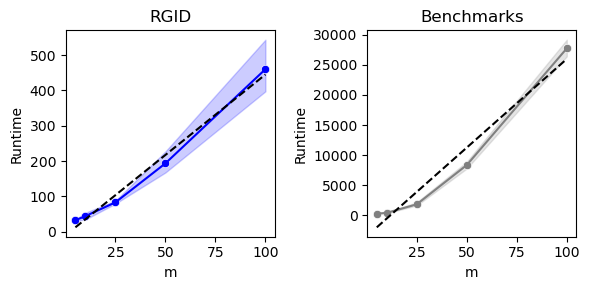

In [ ]:
#Load and analyze supplementary runtime results
seeds = [37902, 37912, 37922, 37932, 37942]
m_list = []
results = []
seed_list = []
grid_res = 10
for m in [5, 10, 25, 50, 100]:
  n_t = 50 #number of terms - Friedman 2001 uses n_t = 20
  _lambda = 2 #mean of the exp distribution that decides interaction sizes. Friedman used 2, Lou FAST paper used 1
  n = 10000 #consistent with Friedman and about the geometric mean of Lou (FAST)
  sn_ratio = 1 #consistent with Friedman
  n_trees = 500
  depth = 20

  for seed in seeds:
    if m == 25:
      benchmark_filepath = 'benchmark_results_nt'+str(n_t)+'_l'+str(_lambda)+'_m'+str(m)+'_n'+str(n)+'_sn' \
      + str(sn_ratio)+'_grid'+str(grid_res)+'_trees'+str(n_trees)+'_depth'+str(depth)+'_seed'+str(seed)+'.joblib'
    else:
      benchmark_filepath = 'benchmark_results_nt'+str(n_t)+'_l'+str(_lambda)+'_m'+str(m)+'_n'+str(n)+'_sn' \
      + str(sn_ratio)+'_trees'+str(n_trees)+'_depth'+str(depth)+'_seed'+str(seed)+'.joblib'
    results.append(joblib.load("Benchmark Results/"+benchmark_filepath))
    m_list.append(m)
    seed_list.append(seed)

#Compute runtimes
dive_runtimes = []
bench_runtimes = []
dive_key_list = ['Feature Imp - DIVE', 'Univariate Interactions - DIVE',
                 'One-way PDPs - DIVE', 'Pairwise Interactions - DIVE',
                 'Two-way PDPs - DIVE', 'Three-way Interactions - DIVE', 'Three-way PDPs - DIVE']
bench_key_list = ['Feature Imp - sklearn', 'Univariate Interactions - H2',
                  'One-way PDPs - sklearn', 'Pairwise Interactions - FAST', 'Two-way PDPs - sklearn']
for r in results:
  dive_runtimes.append(np.sum([v['Runtime'] for k, v in r.items() if k in dive_key_list]))
  bench_runtimes.append(np.sum([v['Runtime'] for k, v in r.items() if k in bench_key_list]))

run_df = pd.DataFrame({
    'm': m_list * 2,
    'Runtime': dive_runtimes + bench_runtimes,
    'Seed': seed_list * 2,
    'Alg.': ['D-GIVE']*len(m_list) + ['Benchmark']*len(m_list)
})
#Plot runtimes
fig, ax = plt.subplots(1,2, figsize = (6,3))
sns.lineplot(data = run_df[run_df['Alg.']=='D-GIVE'], x = 'm', y = 'Runtime', estimator = 'mean', errorbar = ('ci', 95), ax=ax[0], color = 'blue')
sns.lineplot(data = run_df[run_df['Alg.']=='Benchmark'], x = 'm', y = 'Runtime', estimator = 'mean', errorbar = ('ci', 95), ax=ax[1], color = 'gray')
sns.scatterplot(data = run_df[run_df['Alg.']=='D-GIVE'].groupby('m').mean(), x = 'm', y = 'Runtime', color = 'blue', ax = ax[0])
sns.scatterplot(data = run_df[run_df['Alg.']=='Benchmark'].groupby('m').mean(), x = 'm', y = 'Runtime', color = 'gray', ax= ax[1])


dive_xy = run_df[run_df['Alg.']=='D-GIVE'].groupby('m')[['m','Runtime']].mean()
benchmark_xy = run_df[run_df['Alg.']=='Benchmark'].groupby('m')[['m','Runtime']].mean()

plot1_bestfit_x, plot1_bestfit_y = dive_xy['m'], LinearRegression().fit(pd.DataFrame(dive_xy['m']),dive_xy['Runtime']).predict(pd.DataFrame(dive_xy['m']))
plot2_bestfit_x, plot2_bestfit_y = benchmark_xy['m'], LinearRegression().fit(pd.DataFrame(benchmark_xy['m']),benchmark_xy['Runtime']).predict(pd.DataFrame(benchmark_xy['m']))

ax[0].plot(plot1_bestfit_x, plot1_bestfit_y, color = 'black', linestyle = '--')
ax[1].plot(plot2_bestfit_x, plot2_bestfit_y, color = 'black', linestyle = '--')

ax[0].set_title('RGID')
ax[1].set_title('Benchmarks')
fig.tight_layout()


# Healthcare Example - predicting SUD treatment outcome
This section hasn't been 'cleaned' yet, so I haven't provided the data for it. But I have been tinkering with using this model to predict patient characteristics that increase/decrease the likelihood of completing SUD treatment. We published a paper on this dataset last summer in ACM Transactions on MIS.

## Read in and clean df_rehab from ACM TMIS paper

In [ ]:
#Load df_rehab
os.chdir('C:/Users/bauc9/Downloads/data/')

df_rehab=pd.read_pickle("TEDS-D-2006_2019_REHAB_CLEANED.pkl")
#Filter out hospital-based rehab (only 0.15%)
df_rehab=df_rehab[df_rehab.SERVSETD!=3]
df_rehab["SERVSETD_REHAB"]=1*df_rehab["SERVSETD"]-4 #now 0=ST inpatient, 1=LT inpatient, 2=intensive outpatient, 3=nonintensive outpatient

#Eliminate 15 records with missing LOS
df_rehab=df_rehab[df_rehab.LOS>=1]

<ipython-input-5-66c6eb0a9987>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rehab["SERVSETD_REHAB"]=1*df_rehab["SERVSETD"]-4 #now 0=ST inpatient, 1=LT inpatient, 2=intensive outpatient, 3=nonintensive outpatient


In [ ]:
#Specify vector of features for prediction
age_vars=["AGE12_14","AGE15_17","AGE18_20","AGE21_24","AGE30_34","AGE35_39","AGE40_44","AGE45_49","AGE50_54","AGE55+"] #age 25-29 as baseline
gender_vars=["GENDER"]
race_vars=["RACE_HISP","RACE_BLACK","RACE_OTHER"] #non-hispanic white as baseline (modal category)
educ_vars=["EDUC8","EDUC9_11","EDUC13_15","EDUC16+"] #use 12 yrs (modal category) as baseline
employ_vars=["EMP_FULL","EMP_PART","EMP_UN"] #use not in labor force as baseline
homeless_vars=["HOMELESS"]
source_vars=["SOURCE_DRUGPROV","SOURCE_HEALTHPROV","SOURCE_EMPLOYER","SOURCE_COMMUNITY","SOURCE_COURT"] #drop individual referral as baseline
prior_vars=["NOPRIOR"]
sub1_vars=["SUB1_COCAINE","SUB1_MARI","SUB1_HEROIN","SUB1_OPIATES","SUB1_METH","SUB1_OTHER"] #alcohol as baseline
freq1_vars=["FREQ1_2","FREQ1_3","FREQ1_4","FREQ1_5"] #delete no use in the past month as baseline
age1_vars=["AGE1_11","AGE1_12_14","AGE1_18_20","AGE1_21_24","AGE1_25_29","AGE1_30_34","AGE1_35+"] #delete 15-17 as model baseline
sub2_vars=["SUB2_ALCOHOL","SUB2_COCAINE","SUB2_MARI","SUB2_HEROIN","SUB2_OPIATES","SUB2_METH","SUB2_OTHER"] #None as baseline
freq2_vars=["FREQ2_1","FREQ2_2","FREQ2_3","FREQ2_4","FREQ2_5"] #delete zero category as baseline
age2_vars=["AGE2_11","AGE2_12_14","AGE2_15_17","AGE2_18_20","AGE2_21_24","AGE2_25_29","AGE2_30_34","AGE2_35+"] #delete no age as baseline
sub3_vars=["SUB3_ALCOHOL","SUB3_COCAINE","SUB3_MARI","SUB3_HEROIN","SUB3_OPIATES","SUB3_METH","SUB3_OTHER"] #None as baseline
freq3_vars=["FREQ3_1","FREQ3_2","FREQ3_3","FREQ3_4","FREQ3_5"] #delete zero category as baseline
age3_vars=["AGE3_11","AGE3_12_14","AGE3_15_17","AGE3_18_20","AGE3_21_24","AGE3_25_29","AGE3_30_34","AGE3_35+"] #delete no age as baseline
numsub_vars=["NUMSUBS"]
flag_vars=['ALCFLG','COKEFLG','MARFLG','HERFLG','METHFLG','OPSYNFLG','PCPFLG','HALLFLG','MTHAMFLG','AMPHFLG','STIMFLG','BENZFLG','TRNQFLG','BARBFLG','SEDHPFLG','INHFLG','OTCFLG','OTHERFLG']
psyprob_var=["PSYPROB"]
loc_vars=['LOGDENSITY','EP_POV','EP_PCI','EP_UNEMP','EP_NOHSDP','EP_MINRTY','EP_UNINSUR','RPL_THEMES']
methuse_var=["METHUSE"]
serv_rehab_vars=["SERV_RESREHAB_ST","SERV_RESREHAB_LT","SERV_OUTINT","SERV_OUTNONINT"] #HOSP REHAB NOT INCLUDED

#Create xvars and yvar. xvar includes service setting (ST res, LT res, IOP, NOP), but does NOT include LOS (since that is an outcome)
xvars=age_vars+gender_vars+race_vars+educ_vars+employ_vars+homeless_vars+source_vars+prior_vars+sub1_vars \
      +freq1_vars+age1_vars+sub2_vars+freq2_vars+age2_vars+sub3_vars+freq3_vars+age3_vars+numsub_vars+flag_vars+psyprob_var+loc_vars+methuse_var \
      +serv_rehab_vars

yvar="REASON_RC"

In [ ]:
#Collapse frequency vars into new code '2' for some use in past month, '3' for daily use
for sub in [1,2,3]:
  df_rehab[f'FREQ{sub}_some'] = df_rehab[f'FREQ{sub}_2'] + df_rehab[f'FREQ{sub}_3'] + df_rehab[f'FREQ{sub}_4']
  df_rehab[f'FREQ{sub}_daily'] = df_rehab[f'FREQ{sub}_5']
  df_rehab.drop([f'FREQ{sub}_2',f'FREQ{sub}_3',f'FREQ{sub}_4',f'FREQ{sub}_5'], axis = 1,inplace=True)
freq1_vars, freq2_vars, freq3_vars = [[f'FREQ{s}_some',f'FREQ{s}_daily'] for s in [1,2,3]]

xvars=age_vars+gender_vars+race_vars+educ_vars+employ_vars+homeless_vars+source_vars+prior_vars+sub1_vars \
      +freq1_vars+age1_vars+sub2_vars+freq2_vars+age2_vars+sub3_vars+freq3_vars+age3_vars+numsub_vars+flag_vars+psyprob_var+loc_vars+methuse_var \
      +serv_rehab_vars

<ipython-input-7-a5c24c9dfcc3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rehab[f'FREQ{sub}_some'] = df_rehab[f'FREQ{sub}_2'] + df_rehab[f'FREQ{sub}_3'] + df_rehab[f'FREQ{sub}_4']
<ipython-input-7-a5c24c9dfcc3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rehab[f'FREQ{sub}_daily'] = df_rehab[f'FREQ{sub}_5']


In [ ]:
#Format column names
xvars = [x.lower() for x in xvars]
yvar = yvar.lower()
df_rehab.columns = [c.lower() for c in df_rehab.columns]
df_rehab.rename(columns = {'set': 'SET', 'servsetd': 'SERVSETD', 'unique_id': 'UNIQUE_ID'}, inplace = True)

  #Rename other columns
rename_dict = {'source_drugprov': 'referred_sudprovider',
                 'source_healthprov': 'referred_healthprovider',
                 'source_employer':'referred_employer',
                 'source_community': 'referred_otherorg',
                 'source_court': 'referred_court',
                 'noprior': 'num_prior_treatments',
                 'freq1_some': 'sub1_use_pastmonth',
                 'freq1_daily': 'sub1_use_daily',
                 'freq2_some': 'sub2_use_pastmonth',
                 'freq2_daily': 'sub2_use_daily',
                 'freq3_some': 'sub3_use_pastmonth',
                 'freq3_daily': 'sub3_use_daily',
                  'age1_11': 'sub1_age_11',
                  'age1_12_14': 'sub1_age_12_14',
                  'age1_18_20': 'sub1_age_18_20',
                  'age1_21_24': 'sub1_age_21_24',
                  'age1_25_29': 'sub1_age_25_29',
                  'age1_30_34': 'sub1_age_30_34',
                  'age1_35+': 'sub1_age_35+',
                  'age2_11': 'sub2_age_11',
                  'age2_12_14': 'sub2_age_12_14',
                  'age2_18_20': 'sub2_age_18_20',
                  'age2_21_24': 'sub2_age_21_24',
                  'age2_25_29': 'sub2_age_25_29',
                  'age2_30_34': 'sub2_age_30_34',
                  'age2_35+': 'sub2_age_35+',
                  'numsubs': 'num_substances_used',
                  'alcflg': 'any_alc_use',
                  'cokeflg': 'any_cocaine_use',
                 'marflg': 'any_mari_use',
                 'herflg': 'any_heroin_use',
                 'methflg': 'any_methadone_use',
                 'opsynflg': 'any_synth_opioid_use',
                 'pcpflg': 'any_pcp_use',
                 'hallflg': 'any_halluc_use',
                 'mthamflg': 'any_meth_use',
                 'stimflg': 'any_stim_use',
                 'benzflg': 'any_benzo_use',
                 'trnqflg': 'any_tranq_use',
                 'barbflg': 'any_barbit_use',
                 'sedhpflg': 'any_other_sedative_use',
                 'inhflg': 'any_inahalant_use',
                 'otcflg': 'any_otc_use',
                 'otherflg': 'any_other_sub_use',
                 'psyprob': 'mental_health_condition',
                 'logdensity': 'area_pop_density',
                 'ep_pov': 'area_povertyrate',
                 'ep_pci': 'area_percap_income',
                 'ep_unemp': 'area_unemp_rate',
                 'ep_nohsdp': 'area_nohsdiploma_rate',
                 'ep_minrty': 'area_nonwhite_perc',
                 'ep_uninsur': 'area_uninsured_rate',
                 'rpl_themes': 'area_social_vulnerability_index',
                 'methuse': 'medication_asst_opioid_therapy',
                 'serv_resrehab_st': 'treatment_res_shortterm',
                 'serv_resrehab_lt': 'treatment_res_longterm',
                 'serv_outint': 'treatment_intensive_out',
                 'serv_outnoint': 'treatment_nonintensive_out'
                 }
df_rehab.rename(rename_dict, axis = 1, inplace = True)
xvars = [rename_dict[x] if x in rename_dict.keys() else x for x in xvars]

In [ ]:
#Define training and testing sets
n=df_rehab.shape[0]
ns=[np.sum(df_rehab.SERVSETD==s) for s in [4,5,6,7]] #these are the only four service settings

s4_train, s4_val, s4_test=np.array_split(df_rehab.UNIQUE_ID[df_rehab.SERVSETD==4],[int(.6*ns[0]),int(.8*ns[0])])
s5_train, s5_val, s5_test=np.array_split(df_rehab.UNIQUE_ID[df_rehab.SERVSETD==5],[int(.6*ns[1]),int(.8*ns[1])])
s6_train, s6_val, s6_test=np.array_split(df_rehab.UNIQUE_ID[df_rehab.SERVSETD==6],[int(.6*ns[2]),int(.8*ns[2])])
s7_train, s7_val, s7_test=np.array_split(df_rehab.UNIQUE_ID[df_rehab.SERVSETD==7],[int(.6*ns[3]),int(.8*ns[3])])
train_ids=np.concatenate([s4_train,s5_train,s6_train,s7_train])
val_ids=np.concatenate([s4_val,s5_val,s6_val,s7_val])
test_ids=np.concatenate([s4_test,s5_test,s6_test,s7_test])

df_rehab["SET"]=None
df_rehab.loc[df_rehab.UNIQUE_ID.isin(train_ids),"SET"]=0 # 60% of data
df_rehab.loc[df_rehab.UNIQUE_ID.isin(val_ids),"SET"]=1 # 20% of data
df_rehab.loc[df_rehab.UNIQUE_ID.isin(test_ids),"SET"]=2 # 20% of data

df_rehab.SET.value_counts()

0    3703073
1    1234359
2    1234359
Name: SET, dtype: int64

## Train and evaluate classifier model

In [ ]:
#Train a few gradient-boosted treers
SET=0 #use training set

from sklearn.ensemble import HistGradientBoostingClassifier
for i in range(4):
  maxl=[30,30,500,500][i]
  depth=[10,25,10,25][i]
  gb = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=500, max_leaf_nodes=maxl, max_depth=depth,
                  l2_regularization=0.0, max_bins=10, #categorical_features=cat_mask
                  warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1,
                  n_iter_no_change=10, tol=1e-07, verbose=1, random_state=2030,
                  monotonic_cst=None)
  gb.fit(X=df_rehab.loc[df_rehab.SET==SET,xvars],y=df_rehab.loc[df_rehab.SET==0,yvar])
  joblib.dump(gb, f"data/SUD Models/gb_maxl{maxl}_depth{depth}.joblib")
  del gb

In [ ]:
#Train final model with new feature names
SET=0 #use training set

from sklearn.ensemble import HistGradientBoostingClassifier
maxl=500
depth=10
gb = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=500, max_leaf_nodes=maxl, max_depth=depth,
                l2_regularization=0.0, max_bins=10, #categorical_features=cat_mask
                warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1,
                n_iter_no_change=10, tol=1e-07, verbose=1, random_state=2030,
                monotonic_cst=None)
gb.fit(X=df_rehab.loc[df_rehab.SET==SET,xvars],y=df_rehab.loc[df_rehab.SET==0,yvar])
joblib.dump(gb, f"data/SUD Models/gb_maxl{maxl}_depth{depth}.joblib")

In [ ]:
#Check AUCs on validation set
#NOTE: Only the best-performing 10, 500 GB tree was trained on new feature names
#(which use the 'area' prefix). Will need to repeat other models' training to re-compute validation metrics.

gbs = [joblib.load(f"data/SUD Models/gb_maxl{maxl}_depth{depth}.joblib") for maxl, depth in zip([30,30,500,500],[10,25,10,25])]
from sklearn.metrics import roc_auc_score
for maxl, depth in zip([30,30,500,500],[10,25,10,25]):
  gb = joblib.load(f"Interpretable ML Project/SUD Models/gb_maxl{maxl}_depth{depth}.joblib")
  probs = gb.predict_proba(X=df_rehab[df_rehab.SET==1][xvars])[:,1]
  auc = roc_auc_score(df_rehab[df_rehab.SET==1][yvar],probs)
  print(f"AUC {auc} for maxl {maxl} and depth {depth}")


  #From 7/6 12:00pm
# AUC 0.7650363008635246 for maxl 30 and depth 10
# AUC 0.7654726002069194 for maxl 30 and depth 25
# AUC 0.7762920258232358 for maxl 500 and depth 10
# AUC 0.7755671562538811 for maxl 500 and depth 25

In [ ]:
#Select best gradient-boosted classifier
#Load in importance-based random forest
maxl = 500; depth = 10
gb = joblib.load(f"Interpretable ML Project/SUD Models/gb_maxl{maxl}_depth{depth}.joblib")


## Create dashboard

In [ ]:
#Create data subset to speed calculations
sample_frac = 0.02
df_rehab_test = df_rehab[df_rehab.SET==2].sample(frac = sample_frac, random_state = 75019)
X_test = df_rehab_test[xvars]
y_test = df_rehab_test[yvar]

print(f"X_test shape is {X_test.shape}")

X_test shape is (24687, 110)


In [ ]:
#Feature importance plot
import timeit
start = timeit.default_timer()
from sklearn.metrics import log_loss, roc_auc_score
sud_dashboard = run_rgid(X = X_test, y = y_test, metric = neg_auc, model = gb,
                                 grid_size = 20,
                                 partial_out = True,
                                 predict_proba = True,
                                 pdp2_band_width = 0.1,
                                 pdp3_band_width = 0.3,
                                 pdp_ips_trim_q = 0.9,
                                 propensity_samples = 1000,
                                 threeway_int_missing_threshold = 0.25,
                                 feature_limit = 25,
                                 threeway_int_limit = 25,
                                 interaction_quantiles = (0.25, 0.75),
                                 feature_imp_njobs = 1,
                                 propensity_njobs = -1,
                                 threeway_int_njobs = -1,
                                 allow_hover = True)

stop = timeit.default_timer()
runtime = stop - start
print('Time: ', runtime)

joblib.dump(sud_dashboard,  "C:/Users/bauc9/Downloads/data/sud_dashboard_12.2.23.joblib")

In [ ]:
#Show plot
#os.chdir("C:/Users/bauc9/Downloads/data/")
os.chdir('/content/drive/MyDrive/Colab Notebooks/Interpretable ML Project/Dashboard Objects')

sud_dashboard = joblib.load(f"sud_dashboard_12.2.23.joblib")
sud_dashboard['plot']

Output hidden; open in https://colab.research.google.com to view.

Text(0, 0.5, 'Treatment Completion Prob.')

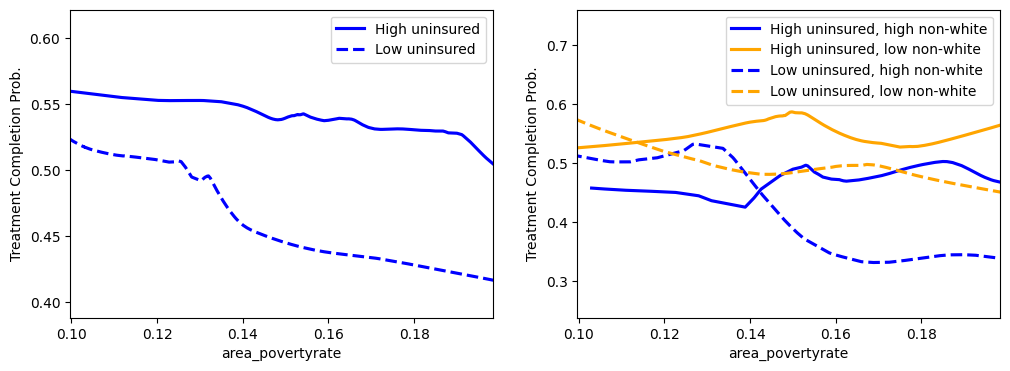

In [ ]:
#Test out uninsured * poverty
df1 = df_rehab[(df_rehab['area_uninsured_rate'] > df_rehab['area_uninsured_rate'].quantile(0.75))]
df0 = df_rehab[(df_rehab['area_uninsured_rate'] <= df_rehab['area_uninsured_rate'].quantile(0.25))]

import seaborn as sns
fig, ax = plt.subplots(1,2 , figsize = (12,4))
sns.regplot(data = df1.sample(10000,random_state=1), x = 'area_povertyrate', y = yvar, lowess= True,
            scatter = False, label = 'High uninsured', color = 'blue', ax = ax[0])
sns.regplot(data = df0.sample(10000,random_state=1), x = 'area_povertyrate', y = yvar, lowess= True,
            scatter = False, label = 'Low uninsured', color = 'blue', ax = ax[0])

ax[0].lines[1].set_linestyle("--")

ax[0].legend()
ax[0].set_xlim(X_test['area_povertyrate'].quantile(0.05), X_test['area_povertyrate'].quantile(0.95))
ax[0].set_ylabel('Treatment Completion Prob.')

#Test out uninsured * nonwhite * poverty
df11 = df_rehab[(df_rehab['area_uninsured_rate'] > df_rehab['area_uninsured_rate'].quantile(0.5)) & (df_rehab['area_nonwhite_perc'] > df_rehab['area_nonwhite_perc'].quantile(0.5))]
df10 = df_rehab[(df_rehab['area_uninsured_rate'] > df_rehab['area_uninsured_rate'].quantile(0.5)) & (df_rehab['area_nonwhite_perc'] < df_rehab['area_nonwhite_perc'].quantile(0.5))]
df01 = df_rehab[(df_rehab['area_uninsured_rate'] < df_rehab['area_uninsured_rate'].quantile(0.5)) & (df_rehab['area_nonwhite_perc'] > df_rehab['area_nonwhite_perc'].quantile(0.5))]
df00 = df_rehab[(df_rehab['area_uninsured_rate'] < df_rehab['area_uninsured_rate'].quantile(0.5)) & (df_rehab['area_nonwhite_perc'] < df_rehab['area_nonwhite_perc'].quantile(0.5))]

import seaborn as sns
sns.regplot(data = df11.sample(100000,random_state=1), x = 'area_povertyrate', y = yvar, lowess= True, scatter = False,
            label = 'High uninsured, high non-white', color = 'blue', ax = ax[1])
sns.regplot(data = df10.sample(100000,random_state=1), x = 'area_povertyrate', y = yvar, lowess= True, scatter = False,
            label = 'High uninsured, low non-white', color = 'orange', ax = ax[1])
sns.regplot(data = df01.sample(100000,random_state=1), x = 'area_povertyrate', y = yvar, lowess= True, scatter = False,
            label = 'Low uninsured, high non-white', color = 'blue', ax = ax[1])
sns.regplot(data = df00.sample(100000,random_state=1), x = 'area_povertyrate', y = yvar, lowess= True, scatter = False,
            label = 'Low uninsured, low non-white', color = 'orange', ax = ax[1])

ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")

ax[1].legend(loc = 'upper right')
ax[1].set_xlim(X_test['area_povertyrate'].quantile(0.05), X_test['area_povertyrate'].quantile(0.95))
ax[1].set_ylabel("Treatment Completion Prob.")
